# Trader Performance vs Market Sentiment

Analyzing how Bitcoin Fear/Greed sentiment relates to trader behavior and performance on Hyperliquid.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
%matplotlib inline

## Part A — Data Preparation

In [2]:
sent = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

print('Sentiment data:', sent.shape)
print('Trader data:', trades.shape)

Sentiment data: (2644, 4)
Trader data: (211224, 16)


In [3]:
print('=== Sentiment ===')
print(sent.dtypes)
print()
print('Missing values:')
print(sent.isnull().sum())
print('Duplicates:', sent.duplicated().sum())
print()
print('=== Trades ===')
print(trades.dtypes)
print()
print('Missing values:')
print(trades.isnull().sum())
print('Duplicates:', trades.duplicated().sum())

=== Sentiment ===
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicates: 0

=== Trades ===
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order I

In [4]:
sent['date'] = pd.to_datetime(sent['date'])
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades['date'] = trades['Timestamp IST'].dt.normalize()

start = trades['date'].min()
end = trades['date'].max()
sent = sent[(sent['date'] >= start) & (sent['date'] <= end)].copy()

print('Overlap:', start.date(), 'to', end.date())
print('Sentiment rows in range:', len(sent))
print('Trade rows:', len(trades))
print()
print('Sentiment breakdown:')
print(sent['classification'].value_counts())

Overlap: 2023-05-01 to 2025-05-01
Sentiment rows in range: 731
Trade rows: 211224

Sentiment breakdown:
classification
Greed            294
Neutral          177
Fear             129
Extreme Greed    116
Extreme Fear      15
Name: count, dtype: int64


### Key Metrics

Building daily aggregated features per trader: daily PnL, win rate, trade count, average trade size, total volume, long/short ratio, unique coins traded.

In [5]:
trades['pnl'] = pd.to_numeric(trades['Closed PnL'], errors='coerce').fillna(0)
trades['size_usd'] = pd.to_numeric(trades['Size USD'], errors='coerce').fillna(0)
trades['fee'] = pd.to_numeric(trades['Fee'], errors='coerce').fillna(0)

daily = trades.groupby(['Account', 'date']).agg(
    total_pnl=('pnl', 'sum'),
    trade_count=('pnl', 'count'),
    positive_trades=('pnl', lambda x: (x > 0).sum()),
    avg_trade_size=('size_usd', 'mean'),
    total_volume=('size_usd', 'sum'),
    buy_count=('Side', lambda x: (x == 'BUY').sum()),
    coins=('Coin', 'nunique'),
    total_fee=('fee', 'sum')
).reset_index()

daily['win_rate'] = daily['positive_trades'] / daily['trade_count']
daily['long_ratio'] = daily['buy_count'] / daily['trade_count']
daily['net_pnl'] = daily['total_pnl'] - daily['total_fee']
daily['is_profitable'] = (daily['net_pnl'] > 0).astype(int)

print('Daily aggregated shape:', daily.shape)
print(daily.head())

Daily aggregated shape: (2341, 14)
                                      Account       date  total_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26     1603.1   

   trade_count  positive_trades  avg_trade_size  total_volume  buy_count  \
0          177                0     5089.718249     900880.13          0   
1           68                0     7976.664412     542413.18          0   
2           40                0    23734.500000     949380.00          0   
3           12                0    28186.666667     338240.00         12   
4           27               12    17248.148148     465700.00         12   

   coins   total_fee  win_rate  long_ratio       net_pnl  is_profitable  
0      

In [6]:
df = daily.merge(sent[['date', 'value', 'classification']], on='date', how='inner')
df.rename(columns={'value': 'fg_value', 'classification': 'fg_class'}, inplace=True)
df['sentiment'] = df['fg_class'].apply(
    lambda x: 'Fear' if 'Fear' in x else ('Greed' if 'Greed' in x else 'Neutral')
)

print('Merged dataset:', df.shape)
print()
print('Records per sentiment:')
print(df['sentiment'].value_counts())

Merged dataset: (2340, 17)

Records per sentiment:
sentiment
Greed      1174
Fear        790
Neutral     376
Name: count, dtype: int64


## Part B — Analysis

### 1. Does Performance Differ Between Fear vs Greed Days?

In [7]:
perf = df.groupby('sentiment').agg(
    mean_pnl=('net_pnl', 'mean'),
    median_pnl=('net_pnl', 'median'),
    mean_winrate=('win_rate', 'mean'),
    mean_trades=('trade_count', 'mean'),
    mean_size=('avg_trade_size', 'mean'),
    mean_long_ratio=('long_ratio', 'mean'),
    count=('net_pnl', 'count')
).round(4)

print(perf.to_string())

            mean_pnl  median_pnl  mean_winrate  mean_trades  mean_size  mean_long_ratio  count
sentiment                                                                                     
Fear       5037.8736    104.5534        0.3571     105.3633  8529.8598           0.5215    790
Greed      4067.4372    235.9174        0.3627      76.9123  5954.6326           0.4723   1174
Neutral    3333.9000    151.3662        0.3554     100.2287  6963.6949           0.4724    376


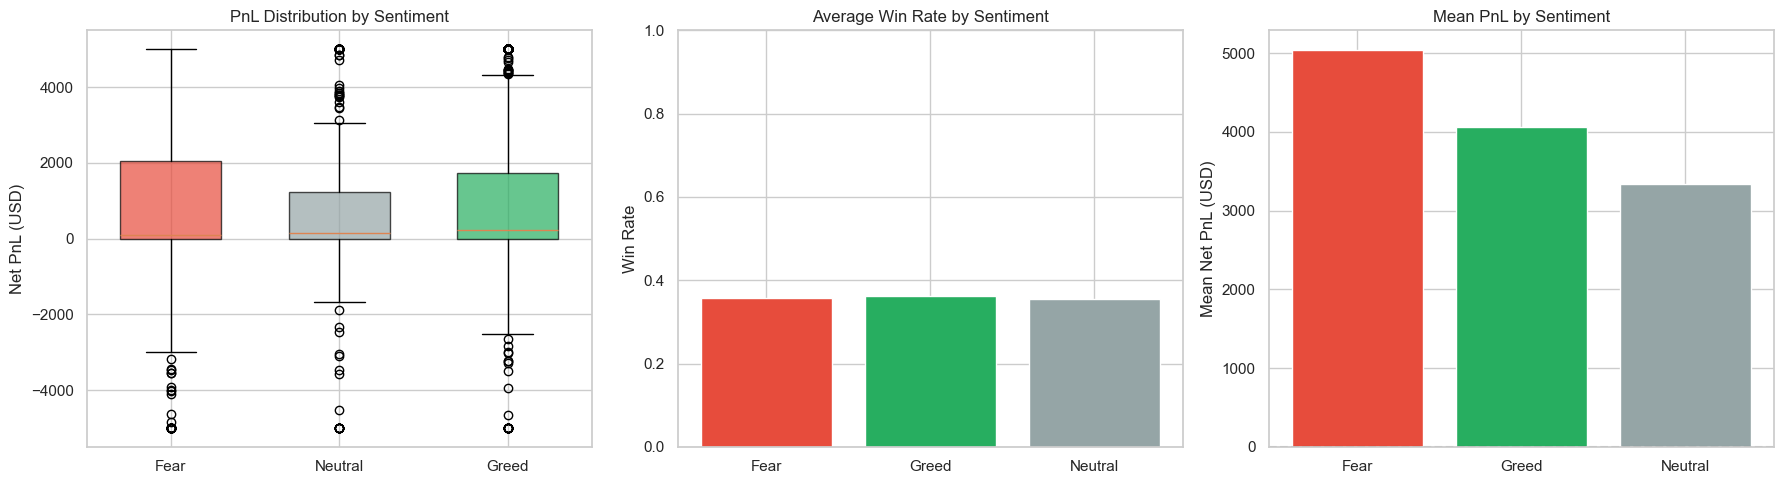

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {'Fear': '#e74c3c', 'Neutral': '#95a5a6', 'Greed': '#27ae60'}

for i, s in enumerate(['Fear', 'Neutral', 'Greed']):
    subset = df[df['sentiment'] == s]['net_pnl']
    if len(subset) > 0:
        axes[0].boxplot([subset.clip(-5000, 5000)], positions=[i], widths=0.6,
                       patch_artist=True, boxprops=dict(facecolor=colors[s], alpha=0.7))
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['Fear', 'Neutral', 'Greed'])
axes[0].set_title('PnL Distribution by Sentiment')
axes[0].set_ylabel('Net PnL (USD)')

wr = df.groupby('sentiment')['win_rate'].mean()
axes[1].bar(wr.index, wr.values, color=[colors.get(x, '#333') for x in wr.index])
axes[1].set_title('Average Win Rate by Sentiment')
axes[1].set_ylabel('Win Rate')
axes[1].set_ylim(0, 1)

pnl_means = df.groupby('sentiment')['net_pnl'].mean()
axes[2].bar(pnl_means.index, pnl_means.values, color=[colors.get(x, '#333') for x in pnl_means.index])
axes[2].set_title('Mean PnL by Sentiment')
axes[2].set_ylabel('Mean Net PnL (USD)')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('chart_pnl_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

### 2. Do Traders Change Behavior Based on Sentiment?

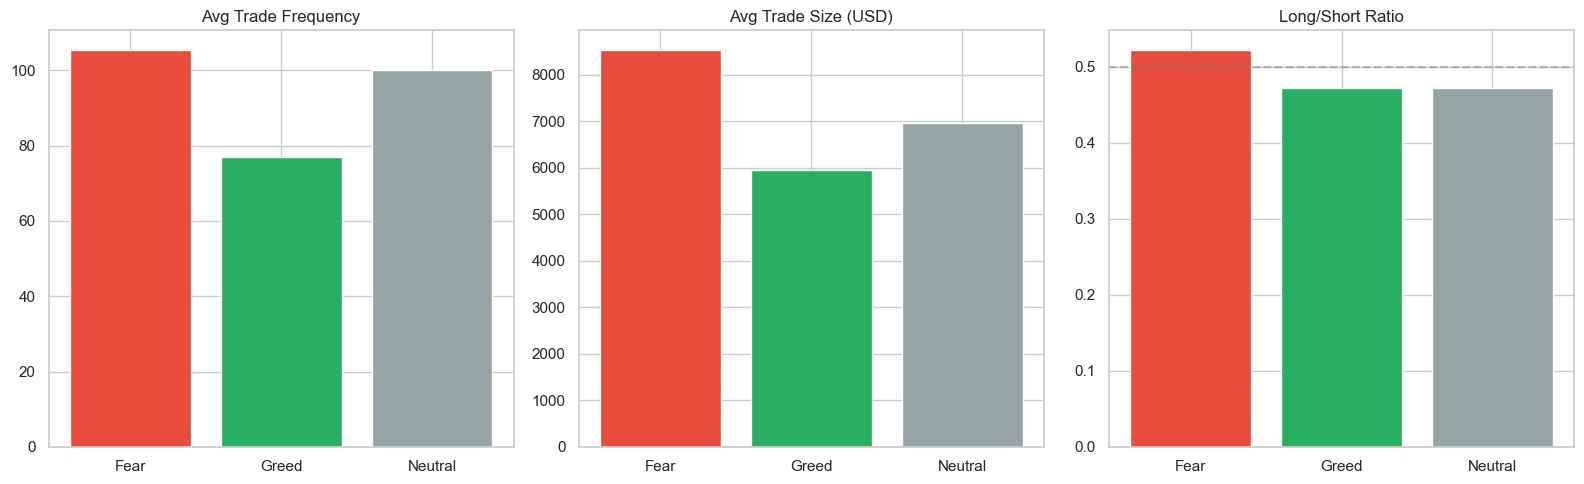

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['trade_count', 'avg_trade_size', 'long_ratio']
titles = ['Avg Trade Frequency', 'Avg Trade Size (USD)', 'Long/Short Ratio']

for i, (col, title) in enumerate(zip(metrics, titles)):
    vals = df.groupby('sentiment')[col].mean()
    axes[i].bar(vals.index, vals.values, color=[colors.get(x, '#333') for x in vals.index])
    axes[i].set_title(title)
    if col == 'long_ratio':
        axes[i].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('chart_behavior_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

### 3. Trader Segments

In [10]:
trader_agg = df.groupby('Account').agg(
    total_pnl=('net_pnl', 'sum'),
    mean_pnl=('net_pnl', 'mean'),
    avg_winrate=('win_rate', 'mean'),
    avg_trades=('trade_count', 'mean'),
    avg_size=('avg_trade_size', 'mean'),
    active_days=('date', 'nunique'),
    total_volume=('total_volume', 'sum'),
    pnl_std=('net_pnl', 'std')
).reset_index()

trader_agg['pnl_std'] = trader_agg['pnl_std'].fillna(0)

size_med = trader_agg['avg_size'].median()
trader_agg['size_seg'] = np.where(trader_agg['avg_size'] >= size_med, 'Large Trader', 'Small Trader')

freq_med = trader_agg['active_days'].median()
trader_agg['freq_seg'] = np.where(trader_agg['active_days'] >= freq_med, 'Frequent', 'Infrequent')

trader_agg['consistency'] = np.where(
    (trader_agg['avg_winrate'] > 0.5) & (trader_agg['total_pnl'] > 0),
    'Consistent Winner', 'Inconsistent'
)

print('Segment counts:')
print('Size:', trader_agg['size_seg'].value_counts().to_dict())
print('Frequency:', trader_agg['freq_seg'].value_counts().to_dict())
print('Consistency:', trader_agg['consistency'].value_counts().to_dict())
print()
print(trader_agg[['Account', 'total_pnl', 'avg_winrate', 'size_seg', 'freq_seg', 'consistency']].head(10))

Segment counts:
Size: {'Large Trader': 16, 'Small Trader': 16}
Frequency: {'Infrequent': 16, 'Frequent': 16}
Consistency: {'Inconsistent': 31, 'Consistent Winner': 1}

                                      Account     total_pnl  avg_winrate  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  1.592825e+06     0.352333   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  4.515548e+04     0.397134   
2  0x271b280974205ca63b716753467d5a371de622ab -7.971717e+04     0.379952   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  1.302464e+05     0.452509   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd  1.655498e+05     0.498708   
5  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -3.135067e+04     0.266215   
6  0x39cef799f8b69da1995852eea189df24eb5cae3c  1.299826e+04     0.364682   
7  0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6  5.331997e+04     0.456899   
8  0x420ab45e0bd8863569a5efbb9c05d91f40624641  1.992376e+05     0.429959   
9  0x430f09841d65beb3f27765503d0f850b8bce7713  4.157949e+05     0.202669

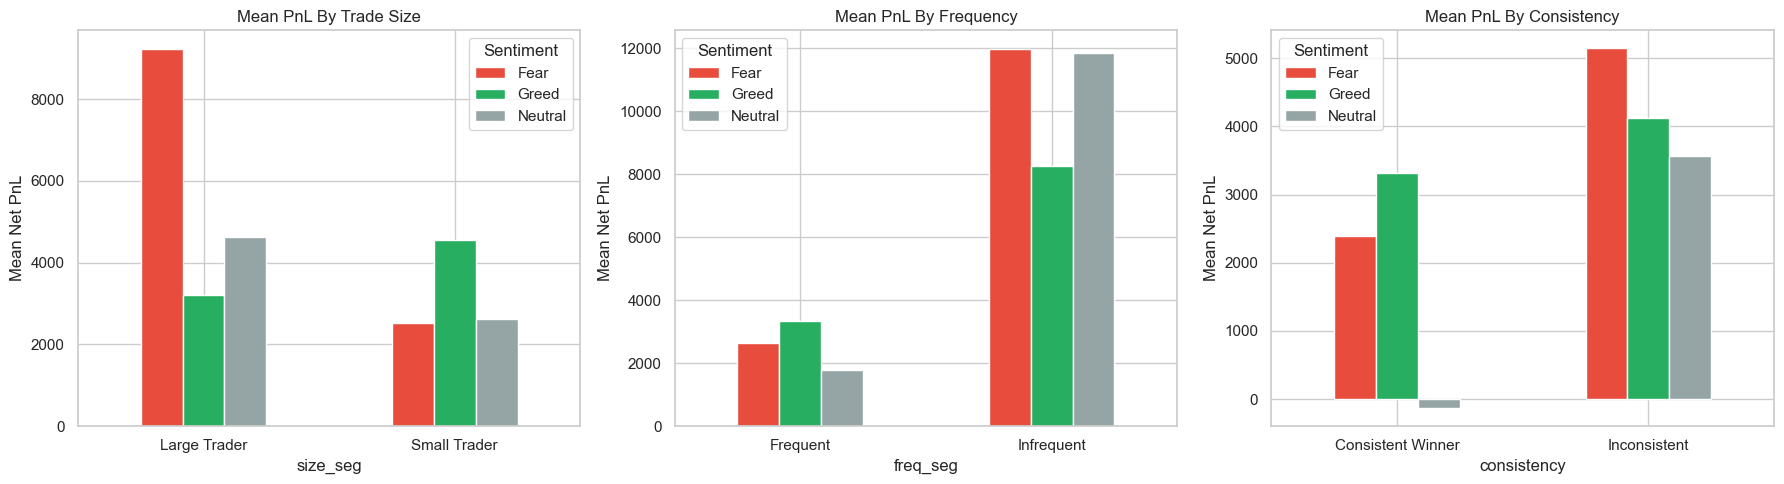

In [11]:
df_seg = df.merge(trader_agg[['Account', 'size_seg', 'freq_seg', 'consistency']], on='Account')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, seg, title in zip(axes, ['size_seg', 'freq_seg', 'consistency'],
                           ['By Trade Size', 'By Frequency', 'By Consistency']):
    grouped = df_seg.groupby([seg, 'sentiment'])['net_pnl'].mean().unstack(fill_value=0)
    grouped.plot(kind='bar', ax=ax, color=[colors.get(c, '#333') for c in grouped.columns])
    ax.set_title(f'Mean PnL {title}')
    ax.set_ylabel('Mean Net PnL')
    ax.legend(title='Sentiment')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('chart_segments.png', dpi=150, bbox_inches='tight')
plt.show()

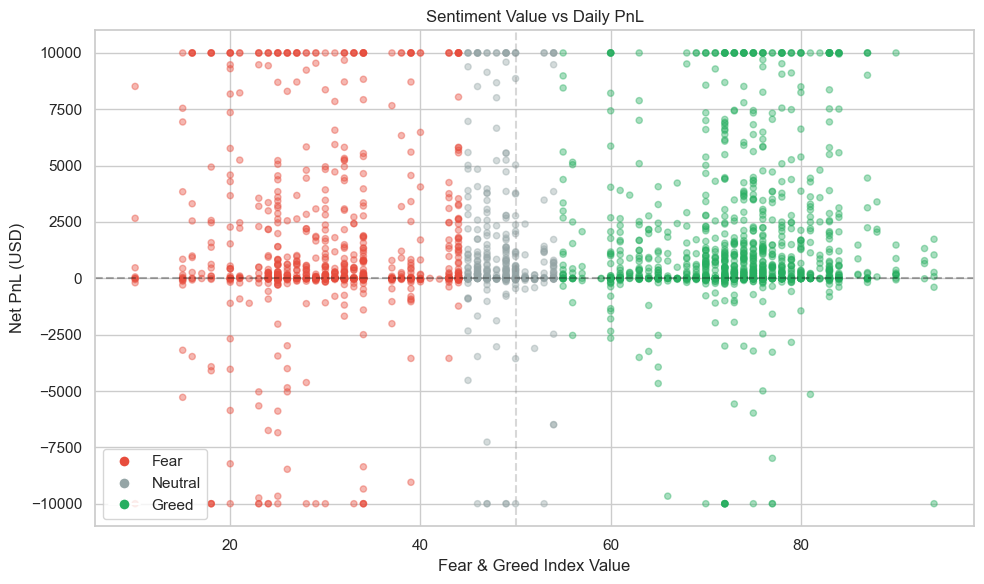

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df['fg_value'], df['net_pnl'].clip(-10000, 10000),
                     c=df['sentiment'].map(colors), alpha=0.4, s=20)
ax.set_xlabel('Fear & Greed Index Value')
ax.set_ylabel('Net PnL (USD)')
ax.set_title('Sentiment Value vs Daily PnL')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.3)

from matplotlib.lines import Line2D
legend_elems = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, label=l, markersize=8)
                for l, c in colors.items()]
ax.legend(handles=legend_elems)

plt.tight_layout()
plt.savefig('chart_scatter_sentiment_pnl.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
sent_map = {'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4}
df['fg_encoded'] = df['fg_class'].map(sent_map).fillna(2).astype(int)
df['day_of_week'] = df['date'].dt.dayofweek

df = df.sort_values(['Account', 'date'])
df['prev_pnl'] = df.groupby('Account')['net_pnl'].shift(1)
df['prev_winrate'] = df.groupby('Account')['win_rate'].shift(1)
df['prev_trades'] = df.groupby('Account')['trade_count'].shift(1)
df['prev_volume'] = df.groupby('Account')['total_volume'].shift(1)
df['rolling_pnl_3d'] = df.groupby('Account')['net_pnl'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['rolling_wr_3d'] = df.groupby('Account')['win_rate'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['pnl_momentum'] = df['net_pnl'] - df['prev_pnl']

model_df = df.dropna(subset=['prev_pnl', 'prev_winrate', 'prev_trades']).copy()

features = ['fg_value', 'fg_encoded', 'trade_count', 'avg_trade_size', 'total_volume',
            'long_ratio', 'coins', 'day_of_week', 'prev_pnl', 'prev_winrate',
            'prev_trades', 'prev_volume', 'rolling_pnl_3d', 'rolling_wr_3d']

X = model_df[features].fillna(0)
y = model_df['is_profitable']

print('Model dataset:', X.shape)
print('Target distribution:')
print(y.value_counts(normalize=True).round(3))

Model dataset: (2308, 14)
Target distribution:
is_profitable
1    0.623
0    0.377
Name: proportion, dtype: float64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_leaf=5,
                            random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

gb = GradientBoostingClassifier(n_estimators=300, max_depth=5, learning_rate=0.1,
                                min_samples_leaf=10, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)

print(f'Random Forest Accuracy: {rf_acc:.4f}')
print(f'Gradient Boosting Accuracy: {gb_acc:.4f}')
print()

best_model = rf if rf_acc >= gb_acc else gb
best_pred = rf_pred if rf_acc >= gb_acc else gb_pred
best_name = 'Random Forest' if rf_acc >= gb_acc else 'Gradient Boosting'

print(f'Best Model: {best_name}')
print()
print(classification_report(y_test, best_pred, target_names=['Not Profitable', 'Profitable']))

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f'Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')

Random Forest Accuracy: 0.8528
Gradient Boosting Accuracy: 0.8680

Best Model: Gradient Boosting

                precision    recall  f1-score   support

Not Profitable       0.85      0.79      0.82       174
    Profitable       0.88      0.91      0.90       288

      accuracy                           0.87       462
     macro avg       0.86      0.85      0.86       462
  weighted avg       0.87      0.87      0.87       462



Cross-validation accuracy: 0.8453 (+/- 0.0251)


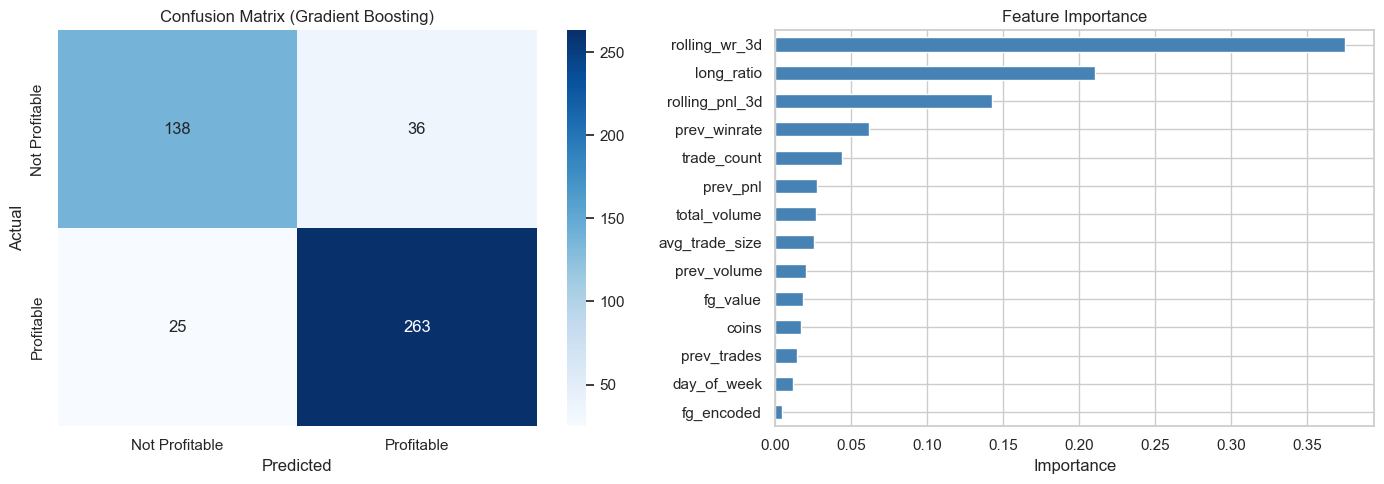

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Profitable', 'Profitable'],
            yticklabels=['Not Profitable', 'Profitable'])
axes[0].set_title(f'Confusion Matrix ({best_name})')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('chart_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Bonus — Trader Clustering

In [16]:
cluster_cols = ['mean_pnl', 'avg_winrate', 'avg_trades', 'avg_size', 'pnl_std', 'active_days']
cluster_data = trader_agg[cluster_cols].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

inertias = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

best_k = 3
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
trader_agg['cluster'] = km_final.fit_predict(X_scaled)

print(f'Clusters (k={best_k}):')
for c in range(best_k):
    members = trader_agg[trader_agg['cluster'] == c]
    print(f'  Cluster {c}: {len(members)} traders, avg PnL={members["mean_pnl"].mean():.2f}, '
          f'avg winrate={members["avg_winrate"].mean():.3f}, avg trades/day={members["avg_trades"].mean():.1f}')

Clusters (k=3):
  Cluster 0: 4 traders, avg PnL=35435.91, avg winrate=0.334, avg trades/day=328.3
  Cluster 1: 8 traders, avg PnL=2768.49, avg winrate=0.416, avg trades/day=91.3
  Cluster 2: 20 traders, avg PnL=2940.19, avg winrate=0.329, avg trades/day=78.0


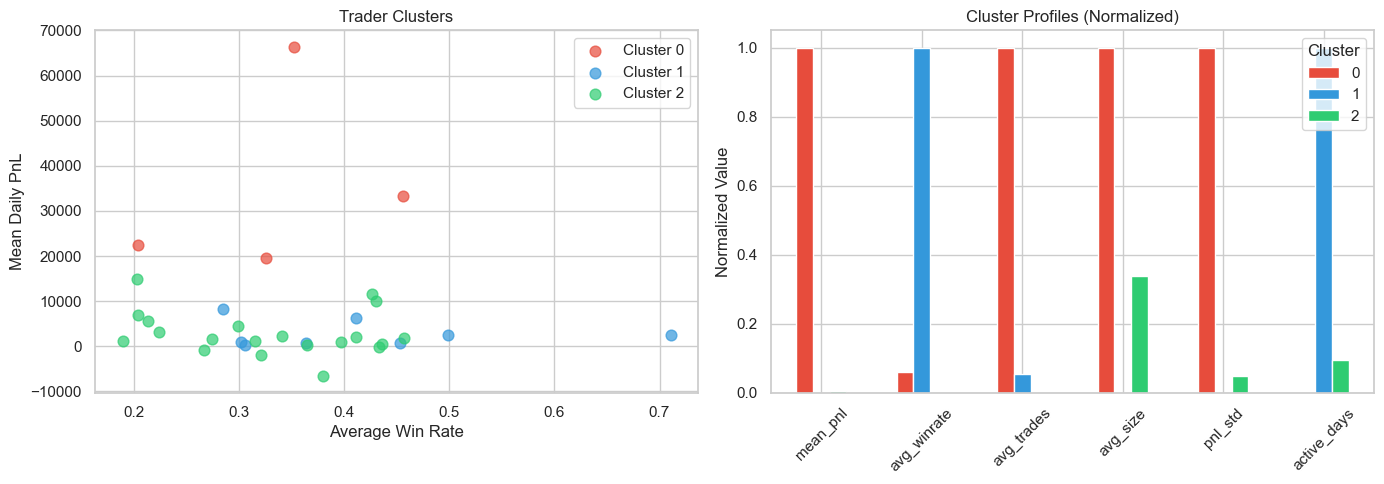

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for c in range(best_k):
    members = trader_agg[trader_agg['cluster'] == c]
    axes[0].scatter(members['avg_winrate'], members['mean_pnl'],
                    c=cluster_colors[c], label=f'Cluster {c}', s=60, alpha=0.7)
axes[0].set_xlabel('Average Win Rate')
axes[0].set_ylabel('Mean Daily PnL')
axes[0].set_title('Trader Clusters')
axes[0].legend()

cluster_profile = trader_agg.groupby('cluster')[cluster_cols].mean()
cluster_profile_norm = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min() + 1e-8)
cluster_profile_norm.T.plot(kind='bar', ax=axes[1], color=cluster_colors[:best_k])
axes[1].set_title('Cluster Profiles (Normalized)')
axes[1].set_ylabel('Normalized Value')
axes[1].legend(title='Cluster')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('chart_clusters.png', dpi=150, bbox_inches='tight')
plt.show()